# Chen & Kipping planet R-M relation

Plots radius vs. mass for solar system, exoplanets, brown dwarfs, and stars following 
Chen & Kipping [2017, ApJ, 834, 17](https://ui.adsabs.harvard.edu/abs/2017ApJ...834...17C), Figure 3.

We introduce a slightly filtered version of their Table 1 data from VizieR 
[J/ApJ/834/17](https://cdsarc.cds.unistra.fr/viz-bin/cat/J/ApJ/834/17), in which we converted their 
.txt file into a suitable .csv file for using pandas.

We also use the masses and radii for well-characterized main sequence stars from Eker et al. 
[2018 MNRAS, 479, 5491](https://ui.adsabs.harvard.edu/abs/2018MNRAS.479.5491E) to add more stars to the stellar
locus in the original Chen & Kipping plot.

Finally, we compile our own database of solar system data, primarily from the JPL Solar System Dynamics
database, and use that instead of the solar system objects in the Chen & Kipping Table 1

## Data Files

 * `MassOrbit_Major.csv` - major solar system bodies masses and orbits (planets, dwarfs, giant moons)
 * `MainSequence_MLR.txt` - main sequence stars with mass, radius, and luminosity data (Eker et al.)
 * `ChenKipping2017-Table1.csv` - Chen & Kipping 2017 Table 1 from above
 * `exoplanets_mr.csv` - masses and radii of confirmed exoplanets (see above)

In [8]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)

## Standard Plot Format

Setup the standard plotting format and make the plot.  

#### Aspect Ratio

`aspect` sets the aspect ratio, width/height.  The default aspect ratio is 4:3, 1:1 for square plots, 
and 5:2 (2.5:1) for spectra, and equal aspect ratio for images and plots of Cartesian coordinates.
Use a formula instead of decimal when the result is a fraction (example: `aspect = 4.0/3.0` instead of
`aspect=1.33`).

In [9]:
# aspect ratio

plotWide = False # wide-screen vs. letter sized

if plotWide:
    aspect = 16.0/9.0 # wide-screen
    aspStr = '16x9'
else:
    aspect = 4.0/3.0
    aspStr = '4x3'

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 0.85

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

# Graphic dimensions depending on bitmap or vector format (draft vs production)

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 8
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)
    
# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## Solar system data

### Planets, Dwarf Planets, and Giant Moons

Planets, dwarf planets, and giant moons are from the JPL Solar System Dynamics database, extracted and organized
into a single CSV file `MassOrbit_Major.csv`.  For this plot we use 4 columns:
 * `Body` - name of the body
 * `a` - orbit semimajor axis in au
 * `ME` - mass in units of M$_E$=5.97271$\times$10$^{24}$ kg
 * `RE` - radius in units of R$_E$=6371 km
 * `Type` - body type code: T = terrestrial planet, G = gas giant, I = ice giant, D = dwarf planet, DC = dwarf planet candidate, GM = giant moon.

In [10]:
majorFile = 'MassOrbit_Major.csv'

data = pd.read_csv(majorFile,comment='#')
bodyName = np.array(data['Body'])
bodyType = np.array(data['Type'])
bodyMass = np.array(data['ME'])
bodyRadius = np.array(data['RE'])
bodyAU = np.array(data['a'])
bodyTeq = 278.0/np.sqrt(bodyAU)

# colors etc.

bodySize = {'T':5,'G':8,'I':6,'D':4,'DC':3,'GM':3}
bodyColor = {'T':'#bbbbbb','G':'beige','I':'cyan','D':'snow','DC':'white','GM':'orange'}

### Stars

The Sun is a main-sequence star, this is Mass, Luminosity, and Radius for well-characterized main sequence
stars from Data are from Eker et al. 2018 MNRAS, 479, 5491.

In [11]:
dataFile = 'MainSequence_MLR.txt'

# M and R sun in earth units

mSunME = 1.98841e30 / 5.97217e24 
rSunRE = 6.957e5 / 6378.1

# read and convert solar to earth units

data = pd.read_csv(dataFile,sep=r'\s+',comment='#')

# convert solar radii and masses to R_E and M_E

rStars = rSunRE*10.0**np.array(data['logR'])
mStars = mSunME*10.0**np.array(data['logM'])

## Chen & Kipping Table 

CSV version of Chen & Kipping Table 1, retrieved from CDS as txt format and converted to a more
convenient format for pandas.

In [12]:
dataFile = 'ChenKipping2017-Table1.csv'
data = pd.read_csv(dataFile,comment='#')

# M and R jupiter in earth units

Mearth = 5.97217e24 # kg
Rearth = 6.3781e6   # m

mJupME = 1.89812e27 / 5.97217e24
rJupRE = 71492.1 / 6378.1

# raw masses, need to convert all to Earth masses

ckMass = np.array(data['Mass'])
ckMassUnits = np.array(data['MassUnits'])
ckRad = np.array(data['Rad'])
ckRadUnits = np.array(data['RadUnits'])

# convert solar to earth masses and radii

iMsun = np.where(ckMassUnits=='Msun')
iMjup = np.where(ckMassUnits=='Mjup')

iRsun = np.where(ckRadUnits=='Rsun')
iRjup = np.where(ckRadUnits=='Rjup')

ckMass[iMsun] *= mSunME
ckMass[iMjup] *= mJupME

ckRad[iRsun] *= rSunRE
ckRad[iRjup] *= rJupRE

## Exoplanet Archive

Masses and radii of confirmed planets with uncertainties in masa and radius <0.2 in Earth units

In [13]:
dataFile = 'exoplanets_mr.csv'
data = pd.read_csv(dataFile,comment='#')

# M and R jupiter in earth units

exoMass = np.array(data['pl_masse'])
exoRad = np.array(data['pl_rade'])

## Solar System Radius-Mass relation

Plot R vs M in Earth radii and masses, following Chen & Kipping 2017, ApJ, 834, 17, Figure 3.

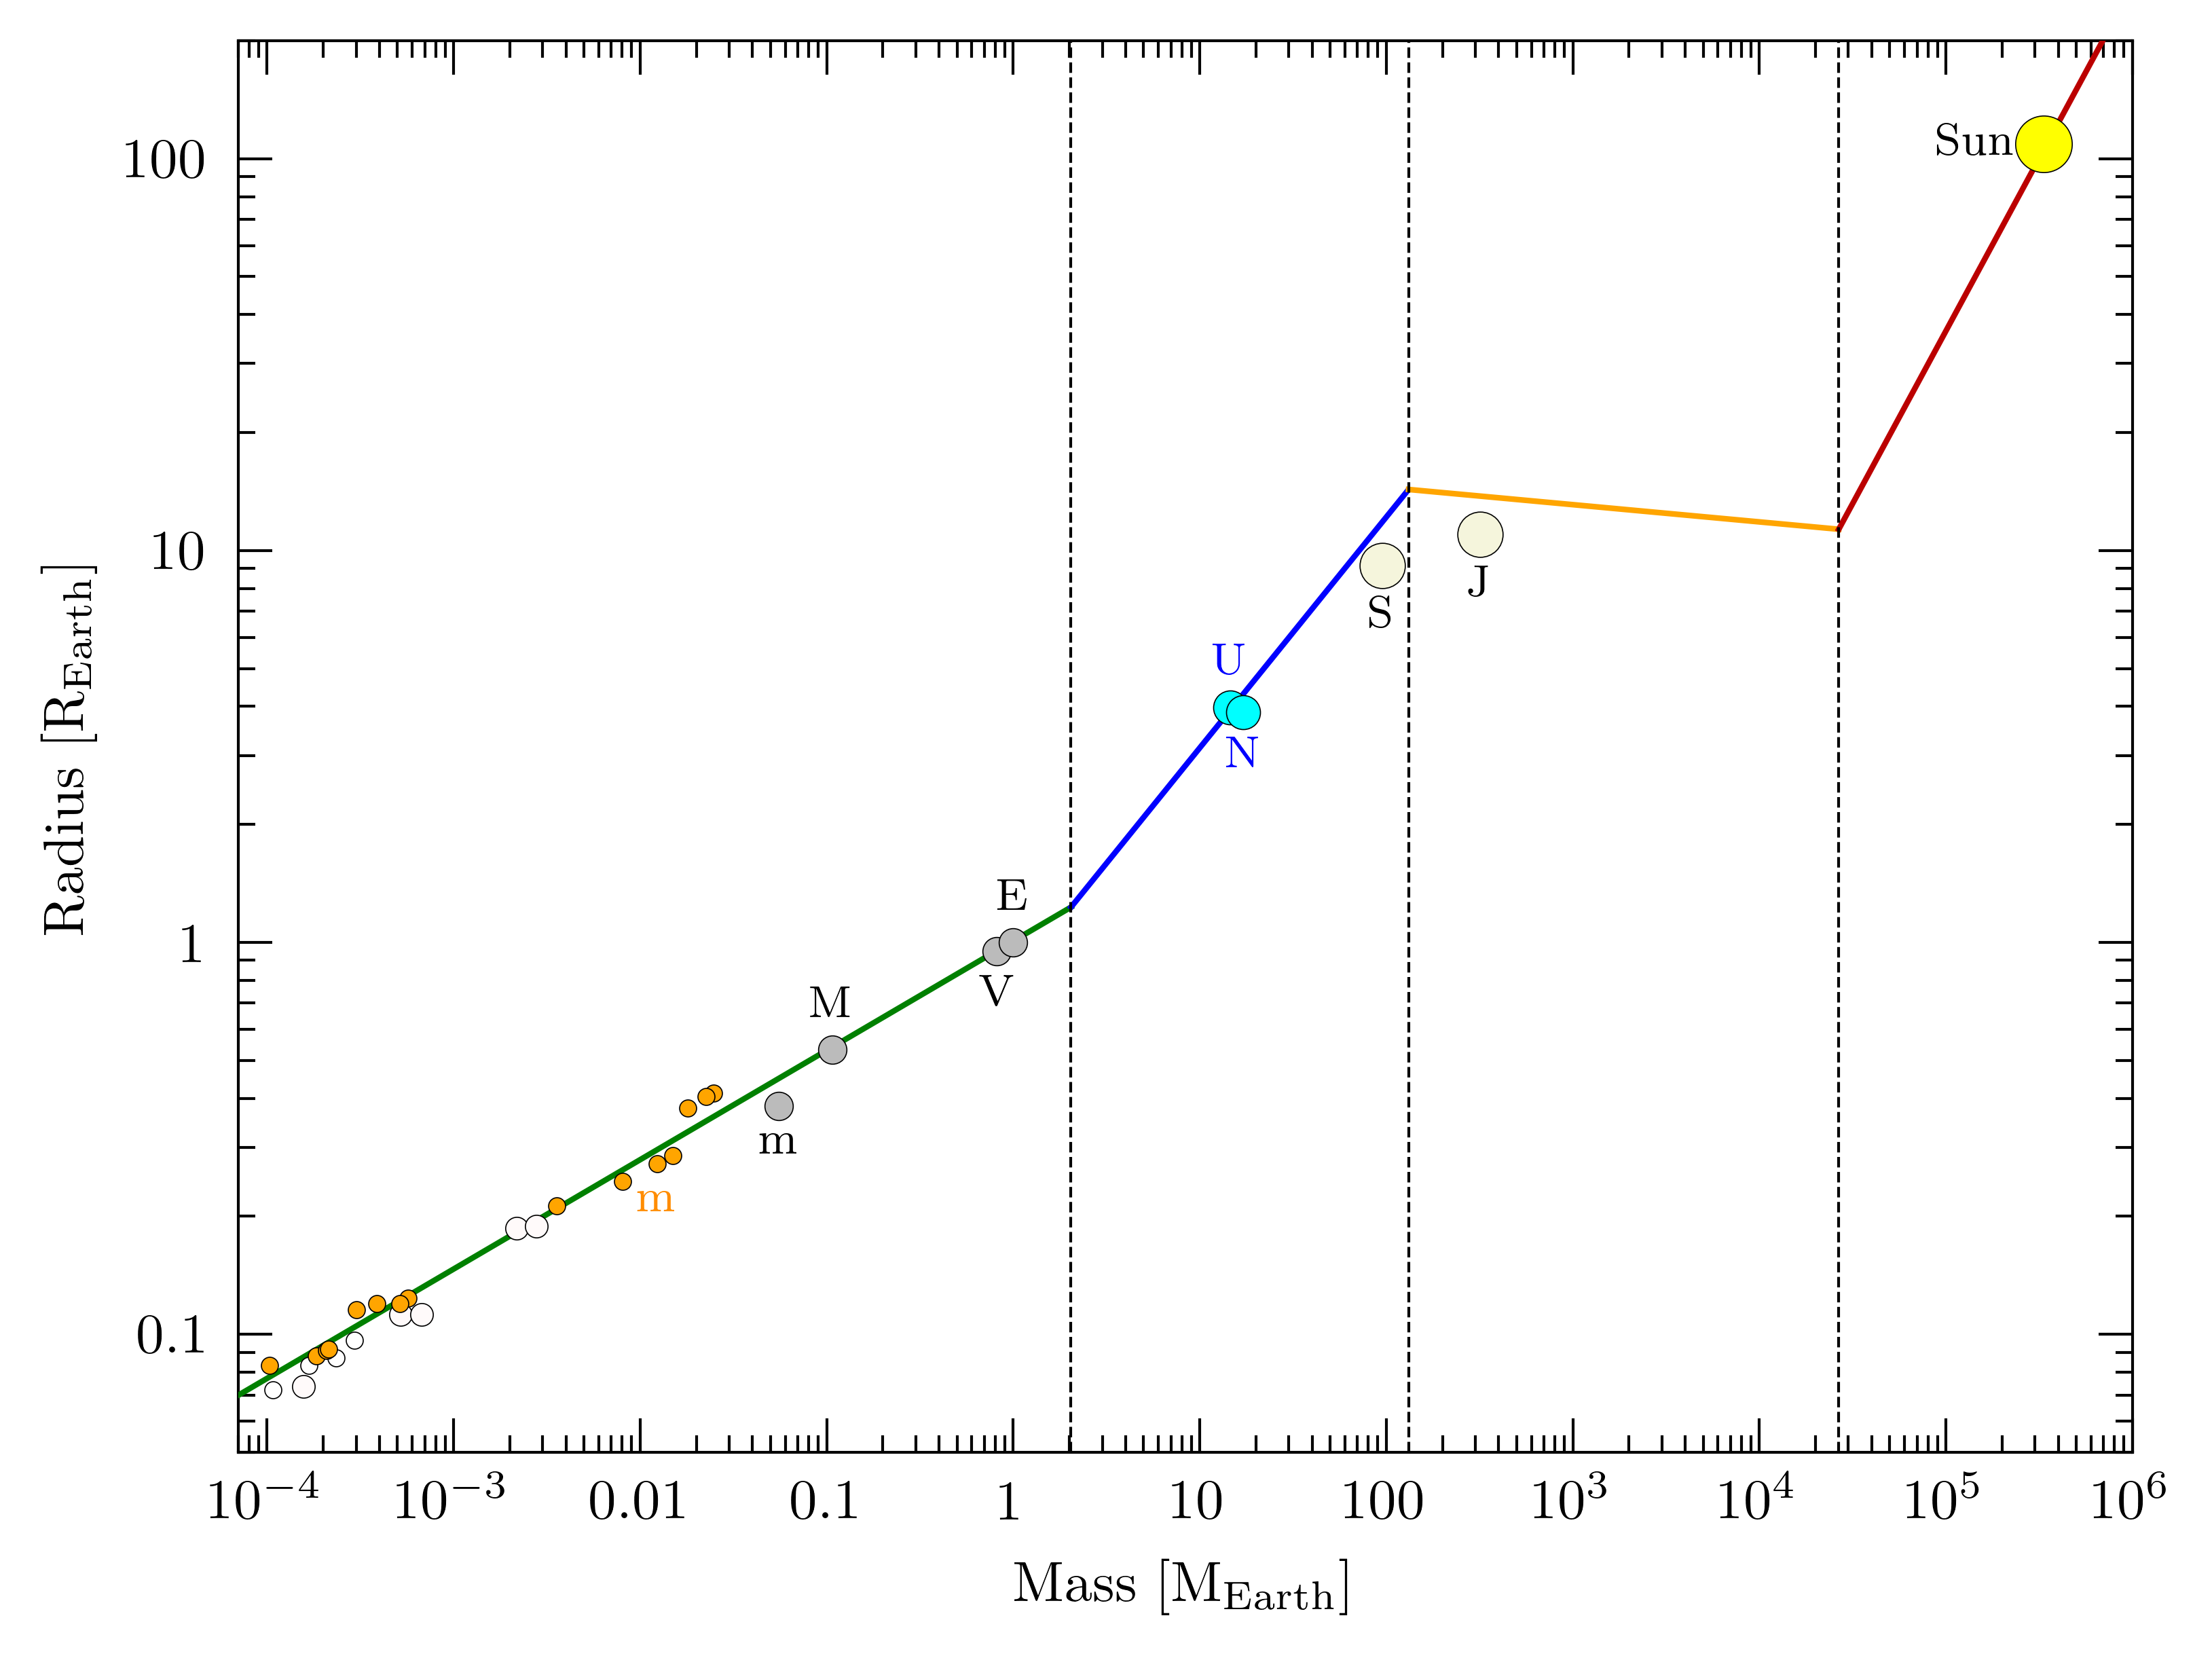

In [14]:
plotAll = False # set True to plot all Chen & Kipping data and supplemntal Eker et al. stars
plotDensity = False # set True to plot contours of constant mass density

densities = [100,300,1000,3000,10000] # kg/m^3

if plotAll:
    if plotDensity:
        plotFile = f'solsys_RMall_rho_{aspStr}.png'
    else:
        plotFile = f'solsys_RMall_{aspStr}.png'
else:
    if plotDensity:
        plotFile = f'solsys_RM_rho_{aspStr}.png'
    else:
        plotFile = f'solsys_RM_{aspStr}.png'
        
# axis limits

mMin = 7.0e-5 # M_earth
mMax = 1.0e6 # M_earth

rMin = 0.05 # R_earth
rMax = 200. # R_earth

# do it

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top=True,right=True)
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top=True,right=True)

ax.set_xlim(mMin,mMax)
ax.set_xscale('log')
ax.xaxis.set_major_locator(LogLocator(base=10.0,subs=(1.0,),numticks=100))
ax.xaxis.set_minor_locator(LogLocator(base=10.0,subs=np.arange(2,10)*0.1,numticks=100))
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks([1e-4,1e-3,0.01,0.1,1,10,100,1e3,1e4,1e5,1e6])
ax.set_xticklabels(['10$^{-4}$','10$^{-3}$','0.01','0.1','1','10','100','10$^3$','10$^4$','10$^5$','10$^6$'])
ax.set_xlabel(r'Mass [M$_{\rm Earth}$]',fontsize=axisFontSize)

ax.set_ylim(rMin,rMax)
ax.set_yscale('log')
ax.yaxis.set_major_locator(LogLocator(base=10.0,subs=(1.0,),numticks=100))
ax.yaxis.set_minor_locator(LogLocator(base=10.0,subs=np.arange(2,10)*0.1,numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel(r'Radius [R$_{\rm Earth}$]',fontsize=axisFontSize)

# Major bodies (planets, dwarf planets, giant moons)

for i in range(len(bodyName)):
    t = bodyType[i]
    
    ax.plot(bodyMass[i],bodyRadius[i],'o',mfc=bodyColor[t],mec='black',ms=bodySize[t],mew=0.2,zorder=10)

    if t == 'D':
        labelTxt = bodyName[i].lower()
    elif t == 'GM':
        if bodyName[i]=='Moon':
            ax.text(bodyMass[i],bodyRadius[i]/1.1,'m',va='top',ha='center',fontsize=labelFontSize,
                    color='darkorange',zorder=10)
    elif t == 'G':
        labelTxt = bodyName[i]
        ax.text(bodyMass[i],bodyRadius[i]/1.2,labelTxt[0],va='top',ha='center',fontsize=labelFontSize,
                color='black',zorder=10)    
    elif t == 'I':
        labelTxt = bodyName[i]
        if bodyName[i] == 'Uranus':
            ax.text(bodyMass[i],1.15*bodyRadius[i],labelTxt[0],va='bottom',ha='center',fontsize=labelFontSize,
                    color='blue',zorder=10)    
        else:
            ax.text(bodyMass[i],bodyRadius[i]/1.15,labelTxt[0],va='top',ha='center',fontsize=labelFontSize,
                    color='blue',zorder=10)    
    elif t == 'T':
        labelTxt = bodyName[i][0]
        if bodyName[i]=='Mercury':
            ax.text(bodyMass[i],bodyRadius[i]/1.1,'m',va='top',ha='center',fontsize=labelFontSize,
                color='black',zorder=10)
        elif bodyName[i]=='Venus':
            ax.text(bodyMass[i],bodyRadius[i]/1.15,labelTxt,va='top',ha='center',fontsize=labelFontSize,
                color='black',zorder=10)          
        else:
            ax.text(bodyMass[i],1.15*bodyRadius[i],labelTxt,va='bottom',ha='center',fontsize=labelFontSize,
                color='black',zorder=10)
            
# Sun

rSun = 6.957e5 / 6378. # R_E
mSun = 1.98841e30 / 5.97217e24 # M_E
ax.plot(mSun,rSun,'o',mfc='yellow',mec='black',ms=10,mew=0.2,zorder=10)
ax.text(mSun/1.4,rSun,'Sun',va='center',ha='right',fontsize=labelFontSize,zorder=10)

# Plot Ekers et al. main-sequence star R-M and all Chen & Kipping data

if plotAll:
    ax.plot(mStars,rStars,'o',mfc='yellow',mec='black',ms=2,mew=0.2,zorder=5)
    ax.plot(ckMass[iMsun],ckRad[iMsun],'o',mfc='yellow',mec='black',ms=2,mew=0.2,zorder=5)
    ax.plot(ckMass,ckRad,'o',mfc='black',mec='black',ms=2,mew=0.2,zorder=4)
    ax.plot(exoMass,exoRad,'o',mfc='black',mec='black',ms=2,mew=0.2,zorder=5)
    
# Terrestrial planet R-M relation

mTI = 2.04 # M_earth
rT0 = 1.008 # R_earth
sT = 0.2790

mT = np.linspace(mMin,mTI,101)
rT = rT0*mT**sT
ax.plot(mT,rT,'-',lw=1,zorder=8,color='green')

# Ice Giant planet R-M relation

mIG = 131.58 # M_E, was 0.414 M_J in paper
sI = 0.589

mI = np.linspace(mTI,mIG,101)
rI = rT[-1]*(mI/mTI)**sI
ax.plot(mI,rI,'-',lw=1,zorder=8,color='blue')
ax.vlines(mTI,rMin,rMax,ls=['--'],colors=['black'],lw=0.5,zorder=8)

# Gas Giant planet R-M relation

mGS = 0.08*mSun # M_E, was 0.08 mSun in paper, mSun here is in M_E
sG = -0.044

mG = np.linspace(mIG,mGS,101)
rG = (rI[-1])*(mG/mIG)**sG
ax.plot(mG,rG,'-',lw=1,zorder=8,color='orange')
ax.vlines(mIG,rMin,rMax,ls=['--'],colors=['black'],lw=0.5,zorder=8)

# Stellar (H-burning MS) R-M relation

sS = 0.881
mS = np.linspace(mGS,1.0e6,101)
rS = (rG[-1])*(mS/mGS)**sS
ax.plot(mS,rS,'-',lw=1,zorder=8,color='#bb0000')
ax.vlines(mGS,rMin,rMax,ls=['--'],colors=['black'],lw=0.5,zorder=8)

# contour of constant density

if plotDensity:
    logMass = np.linspace(-5.0,6.0,101)
    massRho = 10.0**logMass
    for rho in densities:
        radRho = np.cbrt(3*massRho*Mearth/(4*np.pi*rho))/Rearth
        if rho == 1000:
            ax.plot(massRho,radRho,'--',color='blue',lw=0.5,zorder=5)
        else:
            ax.plot(massRho,radRho,':',color='black',lw=0.5,zorder=5)
    
# make the plot and hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='white')

plt.show()